In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

Read data

In [2]:
df1 = pd.read_csv("fixation_data_final.tsv", sep='\t')
df2 = pd.read_csv("einar_siri_fixation.tsv", sep='\t')
df = df1.append(df2)
df.head()


,Recording timestamp,Computer timestamp,Sensor,Project name,Participant name,Recording name,Recording duration,Timeline name,Recording Fixation filter name,Recording software version,...,Fixation point X,Fixation point Y,Fixation point X (MCSnorm),Fixation point Y (MCSnorm),Viewport position X,Viewport position Y,Viewport width,Viewport height,Mouse position X,Mouse position Y
0,0,9036524894,NaN,Gaze_model1,Sigve,Recording3,193565,Timeline1,Tobii I-VT (Fixation),1.145.28180,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,95966,9036620860,Eye Tracker,Gaze_model1,Sigve,Recording3,193565,Timeline1,Tobii I-VT (Fixation),1.145.28180,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,104209,9036629103,Eye Tracker,Gaze_model1,Sigve,Recording3,193565,Timeline1,Tobii I-VT (Fixation),1.145.28180,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,112543,9036637437,Eye Tracker,Gaze_model1,Sigve,Recording3,193565,Timeline1,Tobii I-VT (Fixation),1.145.28180,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,120957,9036645851,Eye Tracker,Gaze_model1,Sigve,Recording3,193565,Timeline1,Tobii I-VT (Fixation),1.145.28180,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The dataframe consists of 79 columns! As such we have to perform a bit of cleaning:

In [3]:
cols_to_keep = ['Recording timestamp', 'Participant name', 'Recording name', 'Gaze point X (MCSnorm)', 'Gaze point Y (MCSnorm)','Eye movement type', 'Eye movement type index','Gaze event duration', 'Fixation point X (MCSnorm)', 'Fixation point Y (MCSnorm)', 'Presented Media name']
df = df[cols_to_keep]

A big part of the data consists of the calibration part of the experiments.
This has to be discarded, which we do by only keeping the rows where the participant looks at the picture in the experiment.

In [4]:
df = df[df["Presented Media name"] == 'test1.png']
df = df[df["Eye movement type"] == "Fixation"]

### Fixation duration
Since our aim is to look at each fixation, we need to keep just one row for each invidual fixation.
They are organized by `'Eye movement type index'`. Because different recordings can contain the same eye movement indices, we only discard the ones that are consecutively identical.

In [5]:
unique_fixations = df[df['Eye movement type index'] != df['Eye movement type index'].shift(1)]

Histograms of fixation duration

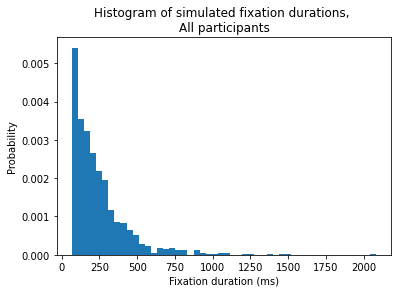

In [54]:
unique_fixations.hist(column='Gaze event duration', bins=50, density=True)
plt.title("Histogram of simulated fixation durations, \nAll participants")
plt.grid(False)
plt.xlabel("Fixation duration (ms)")
plt.ylabel("Probability")
plt.savefig('fix_duration_histogram.png', bbox_inches='tight')
plt.show()


Now we can try to find an exponential distribution that corresponds to the duration data.

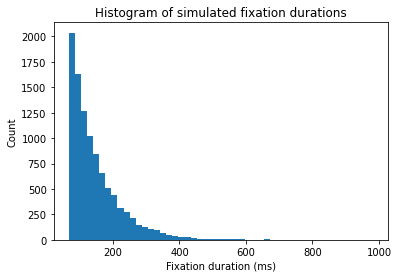

In [53]:
#minimum_duration = unique_fixations['Gaze event duration'].min()
#s = np.random.exponential(scale=80, size=10000) + minimum_duration
#plt.hist(s, bins=50)
#plt.title("Histogram of simulated fixation durations")
#plt.xlabel("Fixation duration (ms)")
#plt.ylabel("Count")
#plt.savefig('fix_duration_histogram.png', bbox_inches='tight')
#plt.show()



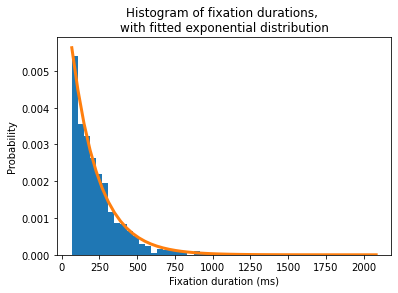

In [58]:
from scipy.stats import expon

count, bins, ignored = plt.hist(unique_fixations['Gaze event duration'], bins=50, density=True)
rv = expon()
#plt.plot(bins, x, lw=2)
#plt.show()

#prob = expon(scale=80, size=10000)
P = expon.fit(unique_fixations['Gaze event duration'])
rP = expon.pdf(bins, *P)
prob = expon.pdf(bins, rP)
plt.plot(bins, rP, lw = 3.0, label="exp")
plt.title("Histogram of fixation durations, \nwith fitted exponential distribution")
plt.xlabel("Fixation duration (ms)")
plt.ylabel("Probability")
plt.savefig('fix_duration_fitted.png', bbox_inches='tight')

plt.show()

### Distance travelled during fixations
Next up is to analyze the average distance from the beginning to the end of a fixation. We will use this to calibrate our $D$ value.

First we need to filter out data so that we end up with the first and last row. We do this by doing the same operation as last time, but this time keeping the last row associated with every 'Eye movement type index'. We then add this to the dataframe with the first row.

Note that because of some problems regarding the data indices and that our data is split in two different .tsv files, we do this separately for each file and then splice the results together in a complete dataframe.

In [30]:
df1 = df1[cols_to_keep]
df1 = df1[df1["Presented Media name"] == 'test1.png']
df1 = df1[df1["Eye movement type"] == "Fixation"]
start1 = df1[df1['Eye movement type index'] != df1['Eye movement type index'].shift(1)]
end1 = df1[df1['Eye movement type index'] != df1['Eye movement type index'].shift(-1)]
fix1 = start1.append(end1)
fix1.sort_index(inplace=True)

In [31]:
df2 = df2[cols_to_keep]
df2 = df2[df2["Presented Media name"] == 'test1.png']
df2 = df2[df2["Eye movement type"] == "Fixation"]
start2 = df2[df2['Eye movement type index'] != df2['Eye movement type index'].shift(1)]
end2 = df2[df2['Eye movement type index'] != df2['Eye movement type index'].shift(-1)]
fix2 = start2.append(end2)
fix2.sort_index(inplace=True)
fix2.head(100)

,Recording timestamp,Participant name,Recording name,Gaze point X (MCSnorm),Gaze point Y (MCSnorm),Eye movement type,Eye movement type index,Gaze event duration,Fixation point X (MCSnorm),Fixation point Y (MCSnorm),Presented Media name
4854,39757788,Einar,Recording3,"0,4613","0,4138",Fixation,121.0,125.0,"0,4665","0,4047",test1.png
4855,39766173,Einar,Recording3,"0,4607","0,4068",Fixation,121.0,125.0,"0,4665","0,4047",test1.png
4862,39824478,Einar,Recording3,"0,4574","0,3937",Fixation,122.0,375.0,"0,4605","0,4022",test1.png
4912,40191161,Einar,Recording3,"0,4606","0,3888",Fixation,122.0,375.0,"0,4605","0,4022",test1.png
4922,40266121,Einar,Recording3,"0,4610","0,4122",Fixation,123.0,108.0,"0,4605","0,4163",test1.png
...,...,...,...,...,...,...,...,...,...,...,...
7336,60381182,Einar,Recording3,"0,4715","0,1546",Fixation,168.0,342.0,"0,4706","0,1569",test1.png
7341,60422897,Einar,Recording3,"0,5846","0,1750",Fixation,169.0,233.0,"0,5912","0,1721",test1.png
7368,60647826,Einar,Recording3,"0,5848","0,1663",Fixation,169.0,233.0,"0,5912","0,1721",test1.png
7404,60947808,Einar,Recording3,"0,5425","0,3169",Fixation,170.0,75.0,"0,5419","0,3267",test1.png


In [32]:
import numpy as np

fixations = fix1.append(fix2)

#fixations = unique_fixations.append(df[df['Eye movement type index'] != df['Eye movement type index'].shift(-1)])
#fixations.sort_index(inplace=True)


fixations.head(10000)
#df[df['Eye movement type index'] != df['Eye movement type index'].shift(-1)].head()


,Recording timestamp,Participant name,Recording name,Gaze point X (MCSnorm),Gaze point Y (MCSnorm),Eye movement type,Eye movement type index,Gaze event duration,Fixation point X (MCSnorm),Fixation point Y (MCSnorm),Presented Media name
7695,63375585,Sigve,Recording3,"0,5187","0,3982",Fixation,141.0,400.0,"0,5202","0,4033",test1.png
7739,63742232,Sigve,Recording3,"0,5210","0,4099",Fixation,141.0,400.0,"0,5202","0,4033",test1.png
7746,63800590,Sigve,Recording3,"0,4475","0,3547",Fixation,142.0,267.0,"0,4516","0,3583",test1.png
7777,64058872,Sigve,Recording3,"0,4498","0,3617",Fixation,142.0,267.0,"0,4516","0,3583",test1.png
7806,64300523,Sigve,Recording3,"0,3192","0,2449",Fixation,143.0,83.0,"0,3314","0,2513",test1.png
...,...,...,...,...,...,...,...,...,...,...,...
32313,97761480,Siri,Recording4,"0,5456","0,6328",Fixation,343.0,325.0,"0,5446","0,6180",test1.png
32319,97811419,Siri,Recording4,"0,5283","0,6169",Fixation,344.0,175.0,"0,5419","0,6053",test1.png
32339,97978078,Siri,Recording4,"0,5444","0,5985",Fixation,344.0,175.0,"0,5419","0,6053",test1.png
32347,98044738,Siri,Recording4,"0,3452","0,4919",Fixation,345.0,592.0,"0,3367","0,5144",test1.png


We also need to remove all 'Eye movement type index' where the first or last row contains invalid data for the gaze point.

In [33]:
# Find all rows where Gaze X or Gaze Y is 'nan'
gaze_point_cols = ['Gaze point X (MCSnorm)', 'Gaze point Y (MCSnorm)']
nan = fixations[gaze_point_cols].isna()

# Create a mask for all rows with an 'Eye movement index' that contains 'nan', with matching 'Participant name'
nan_indices = fixations[nan['Gaze point X (MCSnorm)']][['Eye movement type index', 'Participant name']]

msk = np.zeros(len(fixations), dtype=bool)

for part in nan_indices['Participant name'].unique():
    invalid_ids = nan_indices[nan_indices['Participant name'] == part]['Eye movement type index'].values
    part_mask = (fixations['Participant name'] == part) & (fixations['Eye movement type index'].isin(invalid_ids))
    msk = np.logical_or(msk, part_mask)

# Check fixation rows that matches the mask
fixations[msk]


,Recording timestamp,Participant name,Recording name,Gaze point X (MCSnorm),Gaze point Y (MCSnorm),Eye movement type,Eye movement type index,Gaze event duration,Fixation point X (MCSnorm),Fixation point Y (MCSnorm),Presented Media name
29814,76938035,Siri,Recording4,"0,5620","0,0465",Fixation,270.0,108.0,"0,5602","0,0219",test1.png
29826,77038038,Siri,Recording4,NaN,NaN,Fixation,270.0,108.0,"0,5602","0,0219",test1.png


In [34]:
clean_fixations = fixations[~msk]
start = clean_fixations[clean_fixations['Eye movement type index'] != clean_fixations['Eye movement type index'].shift(1)]
end = clean_fixations[clean_fixations['Eye movement type index'] != clean_fixations['Eye movement type index'].shift(-1)]
# convert values from strings to floats
start = [ (float(x.replace(',', '.')), float(y.replace(',', '.'))) for x, y in start[gaze_point_cols].values]
end = [ (float(x.replace(',', '.')), float(y.replace(',', '.'))) for x, y in end[gaze_point_cols].values]

# Calculate distances for each 'Eye movement type index'
distances = []
for s_point, e_point in zip(start, end):
    # np.linalg.norm gives euclidian distance between points
    distance = np.linalg.norm(np.array(e_point) - np.array(s_point))
    distances.append(distance)



Create a dataframe of each unique fixation, and add distance travelled for each fixation to a 'Distance' column

In [38]:
fix_with_dist = clean_fixations[clean_fixations['Eye movement type index'] != clean_fixations['Eye movement type index'].shift(1)]
fix_with_dist = fix_with_dist.assign(Distance=distances)

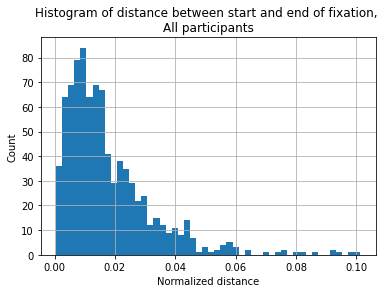

(871, 12)

In [46]:
fix_with_dist.hist(column='Distance', bins=50)
plt.title("Histogram of distance between start and end of fixation, \nAll participants")
plt.xlabel("Normalized distance")
plt.ylabel('Count')
plt.savefig('fix_distance_all.png', bbox_inches='tight')
plt.show()
fix_with_dist.shape


array([[<AxesSubplot:title={'center':'Distance'}>]], dtype=object)

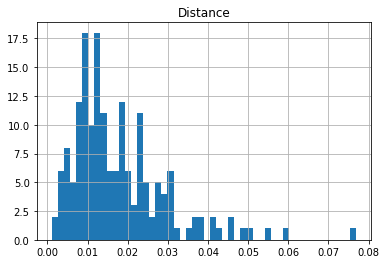

In [43]:
fix_with_dist[fix_with_dist['Participant name'] == 'Einar'].hist(column='Distance', bins=50)